<a href="https://colab.research.google.com/github/whbpt/GREMLIN_CPP/blob/master/GREMLIN_CS_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GREMLIN_simple

This is a bare minimum version of GREMLIN_CS (no gap removal, etc), intended for educational/demo purposes.  For the full version see [GREMLIN_TF_v2.1](https://colab.research.google.com/github/sokrypton/GREMLIN_CPP/blob/master/GREMLIN_TF.ipynb) 

In [0]:
# ------------------------------------------------------------
# "THE BEERWARE LICENSE" (Revision 42):
# <haobowang@fas.harvard.edu> <so@g.harvard.edu> and <pkk382@g.harvard.edu> wrote this code.
# As long as you retain this notice, you can do whatever you want
# with this stuff. If we meet someday, and you think this stuff
# is worth it, you can buy us a beer in return.
# --Sergey Ovchinnikov and Peter Koo
# ------------------------------------------------------------

## Load some libraries

# New Section

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt

## Convert FASTA to MSA np.array()

In [0]:
def parse_fasta(filename):
  '''function to parse fasta file'''
  header = []
  sequence = []
  lines = open(filename, "r")
  for line in lines:
    line = line.rstrip()
    if line[0] == ">":
      header.append(line[1:])
      sequence.append([])
    else:
      sequence[-1].append(line.upper())
  lines.close()
  sequence = [''.join(seq) for seq in sequence]
  return np.array(header), np.array(sequence)
  
def mk_msa(seqs):
  '''one hot encode msa'''
  
  ################
  alphabet = "ARNDCQEGHILKMFPSTWYV-"
  states = len(alphabet)
  a2n = {}
  for a,n in zip(alphabet,range(states)):
    a2n[a] = n

  def aa2num(aa):
    '''convert aa into num'''
    if aa in a2n: return a2n[aa]
    else: return a2n['-']
  ################
  
  msa = []
  for seq in seqs:
    msa.append([aa2num(aa) for aa in seq])
  msa_ori = np.array(msa)
  return msa_ori, tf.keras.utils.to_categorical(msa_ori,states)

## load example

In [0]:
!wget -q -nc https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/4FAZA.fas

In [5]:
names,seqs = parse_fasta("4FAZA.fas")
msa_ori, msa = mk_msa(seqs)

print(msa_ori.shape)
print(msa.shape)

(817, 62)
(817, 62, 21)


## GREMLIN
GREMLIN is technically an "autoencoder" with a single dense (or fully-connected) layer between the input and output, with no hidden variables. GREMLIN tries to minimize the difference between the input and output.  The "latent" variables are the (w)eights/(b)ias of the dense layer.

* loss = categorical_crossentropy(msa,  softmax(dot(msa, w) + b))
 - the math is identical to computing the "pseudolikelihood" as in GREMLIN()
 
* msa
 - msa.shape = (batch, L x 21)
 - 21 =  (20 amino acids + 1 gap) categories
* w = weight
 - w.shape = (L x 21, L x 21)
 -  aka two-body term of the MRF (aka co-evolution)
 -  note: the w matrix is symmetrized and the diagional is set to zero
* b = bias 
 - b.shape = (L x 21)
 - aka one-body-term of the MRF (aka conservation)

In [0]:
def GREMLIN_simple(msa, opt_iter=100):
  
  # collecting some information about input msa
  nrow = msa.shape[0] # number of sequences
  ncol = msa.shape[1] # length of sequence
  states = msa.shape[2] # number of states (or categories)

  # kill any existing tensorflow graph
  tf.reset_default_graph()

  # setting up weights
  b = tf.get_variable("b", [ncol,states])
  w = tf.get_variable("w", [ncol,states,ncol,states], 
                      initializer=tf.initializers.zeros)

  # symmetrize w
  w = w * np.reshape(1-np.eye(ncol),(ncol,1,ncol,1))
  w = w + tf.transpose(w,[2,3,0,1])
  
  # input
  MSA = tf.placeholder(tf.float32,shape=(None,ncol,states),name="msa")

  # dense layer + softmax activation
  MSA_pred = tf.nn.softmax(tf.tensordot(MSA,w,2)+b,-1)

  # loss = categorical crossentropy (aka pseudo-likelihood)
  loss = tf.reduce_sum(tf.keras.losses.categorical_crossentropy(MSA,MSA_pred))

  # add L2 regularization
  reg_b = 0.01 * tf.reduce_sum(tf.square(b))
  reg_w = 0.01 * tf.reduce_sum(tf.square(w)) * 0.5 * (ncol-1) * (states-1)
  loss = loss + reg_b + reg_w

  # setup optimizer
  learning_rate = 0.1 * np.log(nrow)/ncol
  opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)

  # optimize!
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # initialize bias
    pc = 0.01 * np.log(nrow)
    b_ini = np.log(np.sum(msa,0) + pc)
    b_ini = b_ini - np.mean(b_ini,-1,keepdims=True)
    sess.run(b.assign(b_ini))
    
    print("starting",sess.run(loss,{MSA:msa}))

    for i in range(opt_iter):
      sess.run(opt,{MSA:msa})
      if (i+1) % 10 == 0:
        print((i+1),sess.run(loss,{MSA:msa}))

    # save the weights (aka V and W parameters of the MRF)
    V = sess.run(b)
    W = sess.run(w)
  return(V,W) 

In [7]:
%%time
V,W = GREMLIN_simple(msa)

W0830 17:39:02.059383 140428625192832 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


starting 80407.195
10 42247.95
20 38261.23
30 36949.69
40 36504.938
50 36318.098
60 36232.797
70 36190.547
80 36166.117
90 36149.684
100 36137.152
CPU times: user 1.52 s, sys: 662 ms, total: 2.18 s
Wall time: 6.13 s


## get contacts

In [0]:
def get_mtx(W):
  # l2norm of 20x20 matrices (note: we ignore gaps)
  raw = np.sqrt(np.sum(np.square(W[:,:-1,:,:-1]),(1,3)))

  # apc (average product correction)
  ap = np.sum(raw,0,keepdims=True)*np.sum(raw,1,keepdims=True)/np.sum(raw)
  apc = raw - ap
  np.fill_diagonal(apc,0)
  
  return(raw,apc)

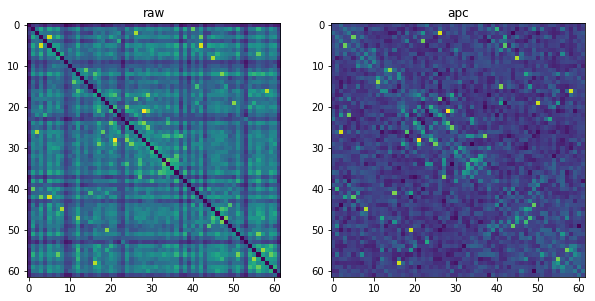

In [9]:
raw, apc = get_mtx(W)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(raw)
plt.grid(False)
plt.title("raw")
plt.subplot(1,2,2)
plt.imshow(apc)
plt.grid(False)
plt.title("apc")
plt.show()

# GREMLIN_CS

In [0]:
def get_H(msa_null,states=21):
  nrow = msa_null.shape[0] # number of sequences
  ncol = msa_null.shape[1] # number of positions

  # compute freq per position
  pssm = np.zeros((msa_null.shape[1],states))
  for i in range(states):
    idx, counts = np.unique(np.where(msa_null == i)[1],return_counts=True)
    pssm[idx,i] = counts/msa_null.shape[0]
  pssm = pssm[:,0:-1]
  pssm = pssm/np.sum(pssm,-1,keepdims=True)
  H = -np.sum(pssm * np.log(pssm+1e-8),1)/np.log(states-1)

  return H

In [0]:
##@title optimization and storage function
def opt_adam(loss, name, var_list=None, lr=1.0, b1=0.9, b2=0.999, b_fix=False):
  # adam optimizer
  # Note: this is a modified version of adam optimizer. More specifically, we replace "vt"
  # with sum(g*g) instead of (g*g). Furthmore, we find that disabling the bias correction
  # (b_fix=False) speeds up convergence for our case.
  
  if var_list is None: var_list = tf.trainable_variables() 
  gradients = tf.gradients(loss,var_list)
  if b_fix: t = tf.Variable(0.0,"t")
  opt = []
  for n,(x,g) in enumerate(zip(var_list,gradients)):
    if g is not None:
      ini = dict(initializer=tf.zeros_initializer,trainable=False)
      mt = tf.get_variable(name+"_mt_"+str(n),shape=list(x.shape), **ini)
      vt = tf.get_variable(name+"_vt_"+str(n),shape=[], **ini)
      
      mt_tmp = b1*mt+(1-b1)*g
      vt_tmp = b2*vt+(1-b2)*tf.reduce_sum(tf.square(g))
      lr_tmp = lr/(tf.sqrt(vt_tmp) + 1e-8)

      if b_fix: lr_tmp = lr_tmp * tf.sqrt(1-tf.pow(b2,t))/(1-tf.pow(b1,t))

      opt.append(x.assign_add(-lr_tmp * mt_tmp))
      opt.append(vt.assign(vt_tmp))
      opt.append(mt.assign(mt_tmp))
        
  if b_fix: opt.append(t.assign_add(1.0))
  return(tf.group(opt))

In [0]:
def categorical_crossentropy(y_true,y_pred,axis=-1):
  return tf.reduce_sum(-y_true * tf.log(y_pred+1e-8),axis)
  

In [0]:
def GREMLIN_CS(msa,
               lambda_=10.0,
               msa_weights=None,
               opt_iter=100,
               batch_size=None,
               reduce_dim=10,
               S1=[],
               mode = "01"):
  
  states = 21
  ent = get_H(msa)
  msa = tf.keras.utils.to_categorical(msa,states)
  msa = msa[:,:,:-1]
  # collecting some information about input msa
  nrow = msa.shape[0] # number of sequences
  ncol = msa.shape[1] # length of sequence
  states = msa.shape[2] # number of states (or categories)
  

  if msa_weights is None:
    msa_weights = np.ones(nrow)
  
  neff = np.sum(msa_weights) # number of "effective" sequences
  
  
  # kill any existing tensorflow graph
  tf.reset_default_graph()
  # setting up weights
  if len(S1) == 0:
    s1 = tf.get_variable("s1",[states,reduce_dim])
  else:
    s1 = tf.Variable(S1,name="s1",trainable = False,)
  

  w = tf.get_variable("w", [ncol,reduce_dim,ncol,reduce_dim],
                    initializer=tf.initializers.zeros)  
  
  # input                
  MSA = tf.placeholder(tf.float32,shape=(None,ncol,states),name="msa")
  MSA_weights = tf.placeholder(tf.float32,shape=(None,),name="msa_weights")
  NEFF = tf.reduce_sum(MSA_weights) 
  # symmetrize w
  w = w * np.reshape(1-np.eye(ncol),(ncol,1,ncol,1))
  w = w + tf.transpose(w,[2,3,0,1])
  w = w - tf.reduce_mean(w,(1,3),keepdims=True)

  #w = tf.einsum("ab,iajc,cd->ibjd",s1,w,s1)
  ### compress the states
  MSA_0 = tf.einsum("ijk,kl->ijl",MSA,s1)
  MSA_1 = tf.einsum("ijk,jklm->ilm",MSA_0,w) 
  MSA_2 = tf.einsum("ijk,lk->ijl",MSA_1,s1) 
  MSA_pred = tf.nn.softmax(MSA_2,-1)
  
  
  s1_mu, s1_var = tf.nn.moments(s1,axes=[0,1])
  s1_loss = tf.square(s1_mu) + s1_var - tf.log(s1_var + 1e-8) - 1.0
  
  if mode[0] == "0": #no entropy fixation in loss function
    loss = tf.reduce_sum(categorical_crossentropy(MSA,MSA_pred),-1) * 0.1
  else:
    loss = tf.reduce_sum(categorical_crossentropy(MSA,MSA_pred)*(1.0-ent),-1)
  loss = tf.reduce_sum(loss * MSA_weights)/NEFF 
  
  if mode[1] == "0": # entropy fixation in two body term
    reg_w = tf.reduce_sum(tf.square(w)) * ncol * lambda_ * (reduce_dim)
  else:  
    reg_w = tf.reduce_sum(tf.exp(w)*w) * ncol * lambda_ * (reduce_dim)

    
  reg = (reg_w)/neff 
  loss = loss + reg  + s1_loss 

  def feed(feed_all=False,bs = batch_size):
    if bs is None or feed_all:
      return {MSA:msa, MSA_weights:msa_weights}
    else:
      idx = np.random.randint(0,nrow,size=bs)
      return {MSA:msa[idx], MSA_weights:msa_weights[idx]}
  ncol_eff = ncol/100.0
  opt_iter = int(np.sqrt(nrow) * opt_iter)
  
  lr = tf.Variable(ncol_eff,name="lr",trainable=False)
  opt = opt_adam(loss,"adam",lr=lr)
  # optimize
  with tf.Session() as sess:
    # initialize
    sess.run(tf.global_variables_initializer())
    # compute loss across all data
    get_loss = lambda: round(sess.run(loss,feed(feed_all=True)) ,2)
    
    for i in range(opt_iter):
      sess.run(opt,feed(bs=batch_size))
      if (i+1) == int(opt_iter*0.2) :
        sess.run(lr.assign(0.1*ncol_eff))
      elif (i+1) == int(opt_iter*0.4) :
        sess.run(lr.assign(0.02*ncol_eff))
      elif (i+1) == int(opt_iter*0.8):
        sess.run(lr.assign(0.005*ncol_eff))
      '''if (i+1) % int(opt_iter/2) == 0:
        print("iter full_loss,regularizer",(i+1),get_loss(),sess.run(reg,feed(feed_all=True)))'''
     
    W = sess.run(w)
    S1 = sess.run(s1)
  # return the learned weights!
  return W,S1

In [0]:
W,S1= GREMLIN_CS(msa_ori,
                 lambda_     = 2.0,
                 msa_weights = None,
                 opt_iter    = 100, 
                 batch_size  = 100,
                 reduce_dim  = 10)

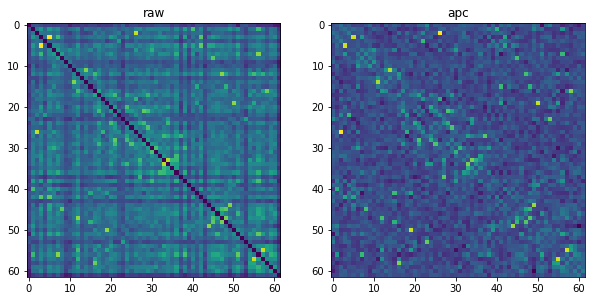

In [15]:
raw, apc = get_mtx(W)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(raw)
plt.grid(False)
plt.title("raw")
plt.subplot(1,2,2)
plt.imshow(apc)
plt.grid(False)
plt.title("apc")
plt.show()

## EXTRA!
Now lets try to learn S1 matrix from some other proteins


In [0]:
!wget -q -nc https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/3CNBA.fas

In [17]:
names,seqs = parse_fasta("3CNBA.fas")
msa_ref, _ = mk_msa(seqs)
print(msa_ref.shape)
## why this protein, because the MSA contains over 20000 sequences

(25947, 143)


In [0]:
## let's get the S1 from the good MSA alignment
W,S1= GREMLIN_CS(msa_ref,
                 lambda_     = 2.0,
                 msa_weights = None,
                 opt_iter    = 100, 
                 batch_size  = 100,
                 reduce_dim  = 10)

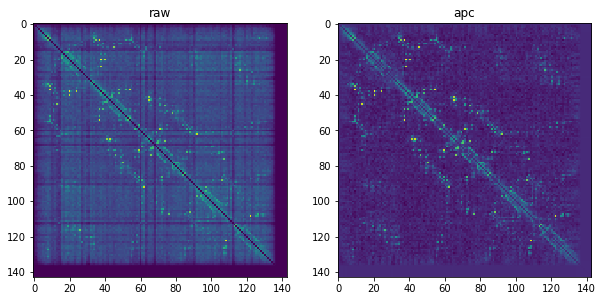

In [19]:
raw, apc = get_mtx(W)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(raw)
plt.grid(False)
plt.title("raw")
plt.subplot(1,2,2)
plt.imshow(apc)
plt.grid(False)
plt.title("apc")
plt.show()

In [0]:
W,S1= GREMLIN_CS(msa_ori,
                 lambda_     = 2.0,
                 msa_weights = None,
                 opt_iter    = 100, 
                 batch_size  = 100,
                 reduce_dim  = 10,
                 S1 = S1) # fix the S1 matrix 

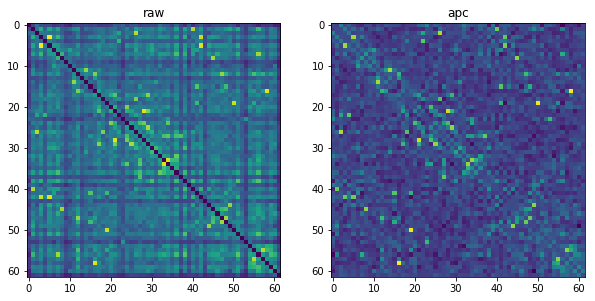

In [21]:
raw, apc = get_mtx(W)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(raw)
plt.grid(False)
plt.title("raw")
plt.subplot(1,2,2)
plt.imshow(apc)
plt.grid(False)
plt.title("apc")
plt.show()

## Try your own protein

In [53]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving msa_amyloid to msa_amyloid
User uploaded file "msa_amyloid" with length 1316302 bytes


In [59]:
names,seqs = parse_fasta(list(uploaded.keys())[0])
msa_query, _ = mk_msa(seqs)
print(msa_ref.shape)

(8074, 131)


In [0]:
W,_ = GREMLIN_CS(msa_query,
                 lambda_     = 2.0,
                 msa_weights = None,
                 opt_iter    = 100, 
                 batch_size  = 100,
                 reduce_dim  = 10,
                 S1 = S1)

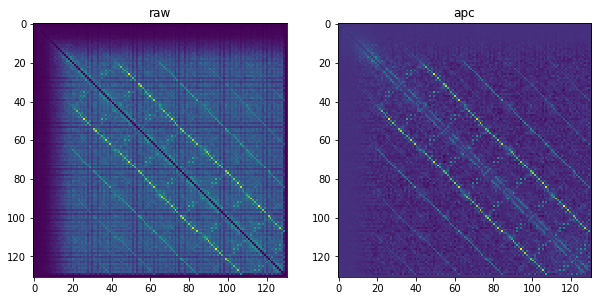

In [62]:
raw, apc = get_mtx(W)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(raw)
plt.grid(False)
plt.title("raw")
plt.subplot(1,2,2)
plt.imshow(apc)
plt.grid(False)
plt.title("apc")
plt.show()